# Individual Machine Learning II Project 1

### Andrew Martinez

## Executive Summary

This report deals with the analysis of turnover at an unidentified firm using an HR data set with the hopes of developing a model to predict future turnover. The model selected for this purpose will be logistic regression with a number of statistical and machine learning techniques implemented in order to optimize its performance (including Manual Feature Creation, Deep Feature Synthesis, Polynomial Features as well as hyperparameter tuning, among others). The final developed model was able to predict turnover at approximately a 96% accuracy across different training/testing partitions when cross-validation was applied. To this extent, it is believed that this final model does a fair job of generalizing on unseen data sets and preventing overfitting.

## Step 1: Data Loading and Library Imports

This first section deals with the import of necessary libraries and functions for this analysis. Custom built functions can be found in the ML_Helper_Function.py file. A simple describe analysis demonstrates that there 10 variables (9 exogenous and 1 endogenous) in the raw data set with a combination of numerical, boolean, and categorical variables present.

In [1]:
import numpy as np
import pandas as pd
import featuretools as ft
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import ML_Helper_Functions as hf #File with custom-built functions
from sklearn import preprocessing
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import classification_report, roc_curve
from IPython.display import HTML
import seaborn as sns
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Load csv from path and provide summary statistics
file_path = '/Users/andrewmartinez/Documents/MBD/Machine Learning II/Individual Project Data/turnover.csv'

raw_df = hf.read_data(file_path)
raw_df.describe(include = 'all')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999,14999
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sales,low
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4140,7316
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,NaN,NaN
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,NaN,NaN
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,NaN,NaN


# Step 2: Data Exploration and Preparation

In this section, further analysis into the data itself as well as preparation for the modeling stages were undertaken. 

In [2]:
raw_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Preliminary analysis reveals that there are no missing values among any of the variables.

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


The following charts reveal that concentrated pockets of turnover exist when an employee exhibits: 1) a sub 50% satisfaction and low average monthly hours (150 and below), 2) high satisfaction level and high average monthly hours as well as 3) very low satisfication level and high average monthly hours. While the third category intuitively makes sense, the first could be explained by employees that are either bored or are part-time contractors and the second high performers who are able to find a better role. 

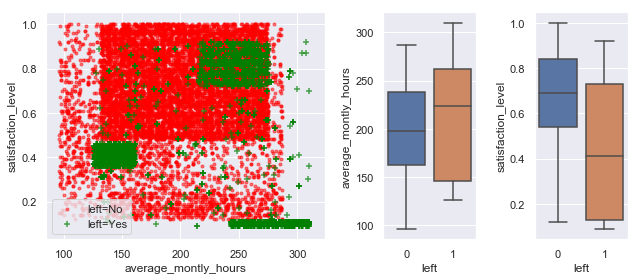

In [4]:
hf.plot_descriptive_satisfaction(raw_df)

The following charts reveal that concentrated pockets of turnover exist when an employee exhibits: 1) a lower last evaluation metric and low average monthly hours and 2) high last evaluation metric and high average monthly hours. The latter group likely falls under the aforementioned "high performers" who find a better role, while the first group are clearly low performers who might have been forced out or moved elsewhere on their own volition.

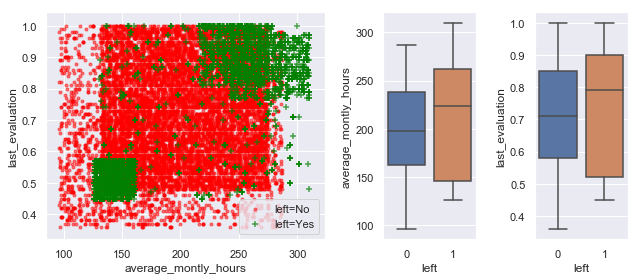

In [5]:
hf.plot_descriptive_last_evaluation(raw_df)

The following chart demonstrates that the majority of employee turnover occurred for medium length tenures (i.e. 2-5 years) with significant peaks at each annual interval (possibly around the time of compensation/performance discussions). While the majority of employees that have remained are also in this tenure bracket, in general employees of both shorter and longer duration tenures tend to remain. As with the previous plots, it is clear that a simple linear combination of these variables will be insufficient to properly partition the two classifications.

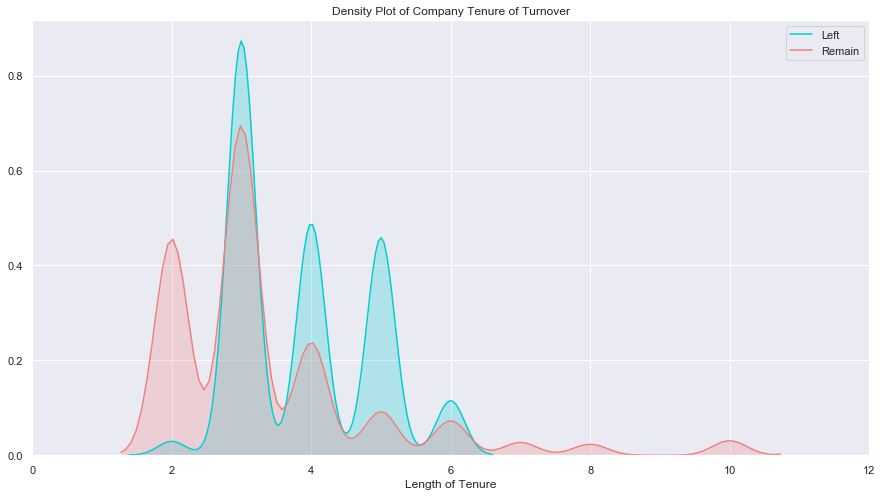

In [6]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(raw_df["time_spend_company"][raw_df.left == 1], color="darkturquoise", shade=True)
sns.kdeplot(raw_df["time_spend_company"][raw_df.left == 0], color="lightcoral", shade=True)
plt.legend(['Left', 'Remain'])
plt.title('Density Plot of Company Tenure of Turnover')
ax.set(xlabel='Length of Tenure')
plt.xlim(0,12)
plt.show()

Similar to previous plots, it can be seen in this graph that employees that have left the firm tend to fall on the two extremes of high and low average monthly hours.

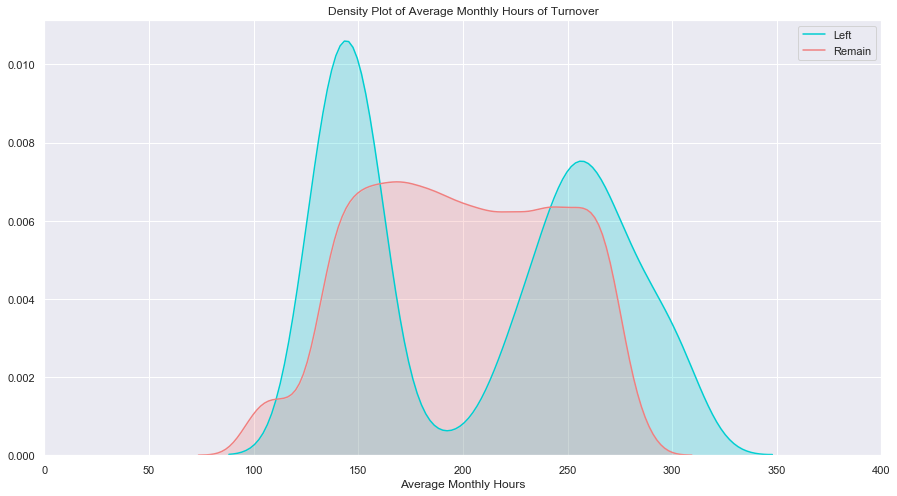

In [7]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(raw_df["average_montly_hours"][raw_df.left == 1], color="darkturquoise", shade=True)
sns.kdeplot(raw_df["average_montly_hours"][raw_df.left == 0], color="lightcoral", shade=True)
plt.legend(['Left', 'Remain'])
plt.title('Density Plot of Average Monthly Hours of Turnover')
ax.set(xlabel='Average Monthly Hours')
plt.xlim(0,400)
plt.show()

In [8]:
#Group variables by variable type
nums = hf.numerical_features(raw_df)
cat = hf.categorical_features(raw_df)
bools = hf.boolean_features(raw_df)

#Override as time_spend_company is actually a cat
nums.drop('time_spend_company')
cat.append('time_spend_company')

It can be seen from the below chart that majority of employees fall under the sales, technical, support, and IT departments.

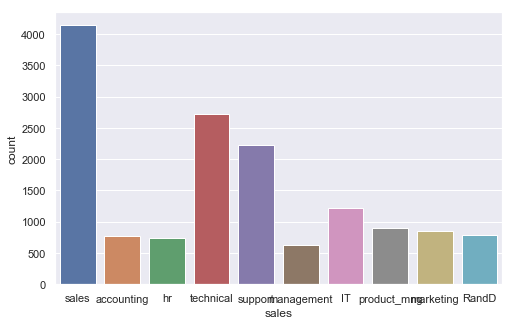

In [9]:
hf.categorical_plot(raw_df, cat, 0)    

It can be seen from the following chart that the majority of employees fall under the low and medium salary bands.

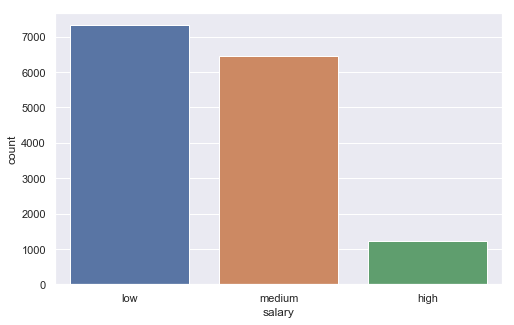

In [10]:
hf.categorical_plot(raw_df,cat, 1)

It can be seen from the following chart that the majority of employees have been with the company approximately 2-4 years.

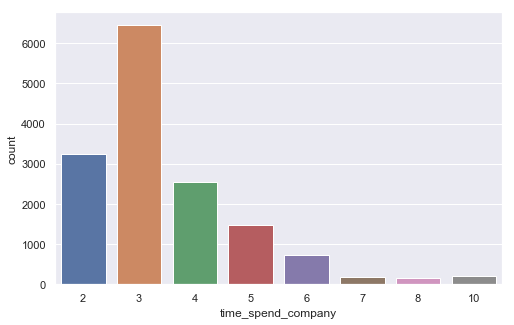

In [11]:
hf.categorical_plot(raw_df,cat, 2)

The categorical variable "salary" will be converted to both a scale variable and dummy variable in order to determine which provides superior performance for the model. Latter stages will test both and keep variables that are more significant to the model.

In [12]:
#Scale the salary variable
categorical_df = hf.categorical_to_scale(raw_df, 'salary')
categorical_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,sal_band
0,0.38,0.53,2,157,3,0,1,0,sales,low,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,1
3,0.72,0.87,5,223,5,0,1,0,sales,low,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,0


In [13]:
#Create dummy variables for categorical variables
encoded_df = hf.onehot_encode(categorical_df, cat)
encoded_df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sal_band,sales_IT,...,salary_low,salary_medium,time_spend_company_2,time_spend_company_3,time_spend_company_4,time_spend_company_5,time_spend_company_6,time_spend_company_7,time_spend_company_8,time_spend_company_10
0,0.38,0.53,2,157,3,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,...,0,1,0,0,0,0,1,0,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0


From the below, it can be determined that although the majority class are the employees that have not left, the data is still fairly balanced.

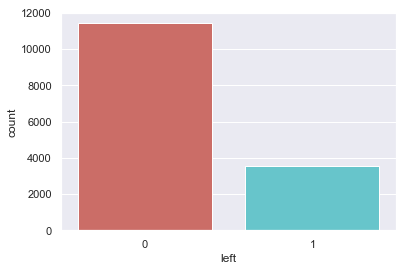

In [14]:
sns.countplot(x='left', data = categorical_df, palette = 'hls')

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


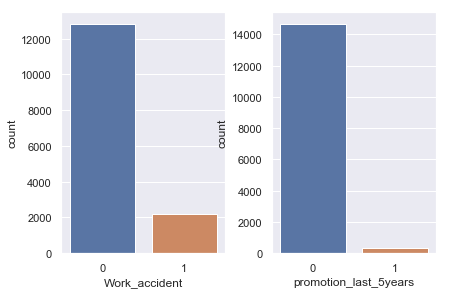

In [15]:
#Keep track of boolean variables after encoding
booleans = hf.boolean_features(encoded_df)

fig, ax = plt.subplots(1,2)
fig.tight_layout()
sns.countplot(encoded_df[booleans[0]], ax=ax[0])
sns.countplot(encoded_df[booleans[2]], ax=ax[1])

fig.show()

Although the previous charts showed that with regards to the promotion variable, the data might not be balanced, the following check allays those concerns as all boolean categories in the data set have a sample size of at least 40 for each category.

In [16]:
#Checks if any boolean variables are imbalanced within sample set
distribution = hf.boolean_dist(encoded_df, booleans)

counter = 0
for col in distribution:
    if col[0] < 40 | col[1] < 40:
        print(col)
    else:
        counter+=1
    
    if counter == len(distribution):
        print("Booleans are balanced")
        

Booleans are balanced


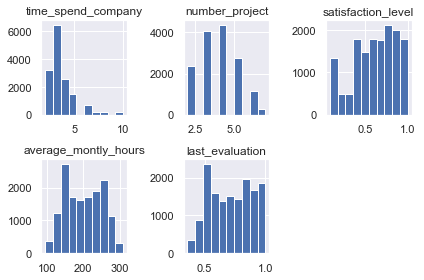

In [17]:
non_bool_numerics = list(set(nums) - set(bools))
hf.draw_histograms(encoded_df, non_bool_numerics, 2, 3)

As it can be seen that some skewness is present in the tenure variable, it will be corrected in this section along with any other variables determined to be skewed. As the data exploration has largely been completed, the data will also be standardized for modeling.

In [18]:
prepared = encoded_df.copy()
prepared[non_bool_numerics] = hf.fix_skewness(encoded_df[non_bool_numerics])
prepared = hf.standardize(prepared, non_bool_numerics)
prepared.head()

/Users/andrewmartinez/Documents/MBD/Machine Learning II/Andrew Martinez/ML_Helper_Functions.py:174: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  standardized_numericals = preprocessing.scale(df[numerical_values])


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sal_band,sales_IT,...,salary_low,salary_medium,time_spend_company_2,time_spend_company_3,time_spend_company_4,time_spend_company_5,time_spend_company_6,time_spend_company_7,time_spend_company_8,time_spend_company_10
0,-0.936495,-1.087275,-1.462863,-0.882040,-0.184396,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,0.752814,0.840707,0.971113,1.220423,1.632127,0,1,0,1,0,...,0,1,0,0,0,0,1,0,0,0
2,-2.022479,0.957554,2.593763,1.420657,0.626260,0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,0
3,0.431041,0.899131,0.971113,0.439508,1.200633,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,-0.976716,-1.145699,-1.462863,-0.841993,-0.184396,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0


After conducting correlation analysis, it can be seen that a few variables such as satisfaction and tenure have some correlation with the turnover variable. Furthermore, multicollinearity does not appear to a substantial issue which the exception of the created salary variables, which would intuitively make sense.

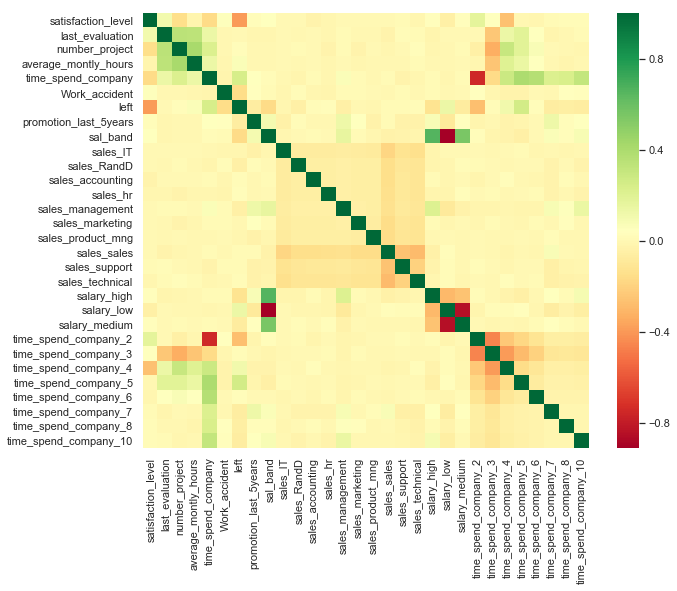

In [19]:
plt.figure(figsize=(10,8)) 
sns.heatmap(prepared.corr(), cmap="RdYlGn")
plt.show()

# Step 3: Train Baseline Model

This section of the analysis deals with the creation and testing of the baseline model. This model will use the cleaned data as it currently stands and exhibit no feature creation nor hyperparameter tuning. It will serve as the benchmark against all subsequent model changes.

In [20]:
# Split into train and test sets
size = 0.20
seed = 12345
target = 'left'
target_metric = 'accuracy'

features = list(prepared)
features.remove(target)

dependent_var = [target]
X = prepared.loc[:, features]
y = prepared.loc[:, dependent_var]

X = hf.correlation_removal(X)

Need to remove 0 columns with >= 0.99 correlation.


In [21]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=seed)

In [22]:
#Baseline Model
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.367748
         Iterations: 35
                                     Results: Logit
Model:                       Logit                   Pseudo R-squared:        0.330     
Dependent Variable:          left                    AIC:                     11081.7172
Date:                        2019-02-17 18:25        BIC:                     11272.1106
No. Observations:            14999                   Log-Likelihood:          -5515.9   
Df Model:                    24                      LL-Null:                 -8232.3   
Df Residuals:                14974                   LLR p-value:             0.0000    
Converged:                   0.0000                  Scale:                   1.0000    
No. Iterations:              35.0000                                                    
----------------------------------------------------------------------------------------
                       Coef.     Std.Err.      z     P>|z|      [0.025         0.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


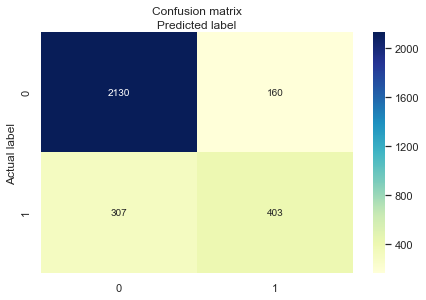

In [23]:
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
    
hf.confusion_heat_map(y_test, y_pred)

In [24]:
print('BASE LINE:')
print('Accuracy of logistic regression classifier on hold-out set: {:.2f}'.format(logreg.score(X_test, y_test)))
accuracy = hf.cv_evaluate(df = prepared, target_var = target, seed = seed)
print('Mean Accuracy after CV: {:.3f} +/- {:.03f}'.format(np.mean(accuracy), np.std(accuracy)))
print('Best Accuracy after CV: {:.3f}'.format(max(accuracy)))
print()
print(classification_report(y_test, y_pred))

BASE LINE:
Accuracy of logistic regression classifier on hold-out set: 0.84
Mean Accuracy after CV: 0.838 +/- 0.006
Best Accuracy after CV: 0.847

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2290
           1       0.72      0.57      0.63       710

   micro avg       0.84      0.84      0.84      3000
   macro avg       0.79      0.75      0.77      3000
weighted avg       0.84      0.84      0.84      3000



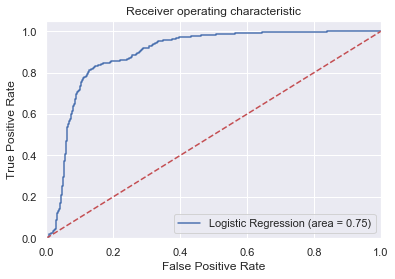

In [25]:
hf.ROC_curve(logreg, y_test, X_test)

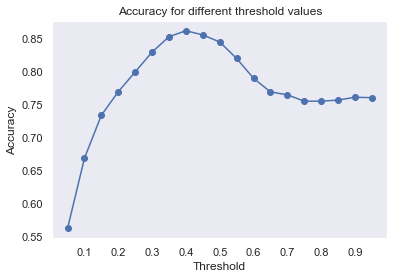

In [26]:
accuracy_list, threshold_list = hf.get_accuracy_list(logreg, X_test, y_test, y_pred)
hf.accuracy_plot(accuracy_list, threshold_list)

# Step 4 - Pipeline 1: Custom Feature Engineering and Deep Feature Synthesis

This section covers the first pipeline that will utilize a combination of manual feature engineering and Deep Feature Synthesis (DFS) for the purpose of creating new variables.

# Manual Feature Engineering

The manual feature engineering portion covers several functions including the removal of under represented features, calculating the average number of projects per year an employee undertakes, binning of continuous variables, and removal of outliers. 

According to the results, removal of under represented features and outliers had little effect (as there were no such features), while projects per year and binning had material effects on accuracy. Intuitively, projects per year could have an effect as an overworked employee undertaking many projects simultaneously would be more motivated to leave. Likewise, binning continuous variables would help improve the model as a marginal discrete change in variables such as monthly hours or number of projects would be less helpful in determining turnover than determining whether an employee falls into a higher or lower bucket in these categories.

In [27]:
# Remove outliers has been excluded to improve pipeline performance. Previous runs determined
# that no outliers were present.
fe_functions = ['under_represented_features', 'projects_per_year', 'bin_continuous_var']
#, 'remove_outliers']

engineering_data_total = X.join(y)
engineering_data_test = X_train.join(y_train)

funcs, new_dataset = hf.feature_engineering_pipeline(engineering_data_total, engineering_data_test, 
                                                     target, size, seed, fe_functions)
accuracy = hf.cv_evaluate(new_dataset, target, seed = seed)
print('Mean Accuracy after CV: {:.3f} +/- {:.03f}'.format(np.mean(accuracy), np.std(accuracy)))
print('Best Accuracy after CV: {:.3f}'.format(max(accuracy)))


Base Accuracy on Training Set: 0.8296
- New Accuracy (under_represented_features): 0.8296 [diff: 0.0000] [Accepted]
- New Accuracy (projects_per_year): 0.9171 [diff: 0.0875] [Accepted]
- New Accuracy (bin_continuous_var): 0.9150 [diff: -0.0021] [Accepted]
Mean Accuracy after CV: 0.921 +/- 0.006
Best Accuracy after CV: 0.933


# Deep Feature Synthesis

DFS was implemented in order to create a richer set of possible variables to train the model from the existing set. This allows for automated feature engineering by creating new features like the summation, max, min, mode, standard deviation, etc. of existing features. Different methods are utilized to reduce this set including removing those related to booleans (the max or min of a boolean has no inherent meaning), checking for variables with very high correlation as well as RFECV to find the optimal set of variables that maximizes the accuracy across different Kfolds.

In [28]:
#Create new entityset
es = ft.EntitySet()
es = es.entity_from_dataframe(entity_id='employees', dataframe = new_dataset,index = 'Id')

#Normalize entityset
es.normalize_entity(base_entity_id='employees', new_entity_id='employees_norm',index='Id')

2019-02-17 18:26:09,009 featuretools.entityset - WARNING    index Id not found in dataframe, creating new integer column


Entityset: None
  Entities:
    employees [Rows: 14999, Columns: 39]
    employees_norm [Rows: 14999, Columns: 1]
  Relationships:
    employees.Id -> employees_norm.Id

In [29]:
features, feature_names = ft.dfs(entityset=es, target_entity='employees_norm', verbose = 1, 
                                 max_depth = 2)

Built 200 features
Elapsed: 04:27 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


# Feature Reduction

Several hundred features were created from the feature engineering process, however a number that are irrelevant or not useful for the final model. This process begins with features that intuitively should not be included, starting with any engineered features that are related to the target variable and booleans will be removed. In the case of the former, these would be self-referential, artificially increasing the model's accuracy and in case of the latter, many of these features have no inherent meaning (e.g. the min of a boolean). Furthermore, variables found to be highly correlated will be removed as well to prevent multicollinearity. Finally, some engineered variables resulted in entire columns of NaNs (likely due to operations that divided by 0), which will also be removed.

With these features out of the way Recursive Feature Elimination (RFE) is employed in order to determine the optimal set of features. This makes use of cross validation on the training set with the hopes of creating a less complex model that will minimize overfitting, but still provides the best possible accuracy on the training set.

In [30]:
#Remove features related to the target and booleans features (as the MIN of a boolean has no real
#meaning).
drop_cols = []

for col in features:
    if col == target:
        pass
    else:
        if (target in col) | ('sales' in col) | ('salary' in col) | ('accident' in col):
            drop_cols.append(col)

print('Need to drop columns:', drop_cols)
features = features[[x for x in features if x not in drop_cols]]

Need to drop columns: ['SUM(employees.Work_accident)', 'SUM(employees.sales_IT)', 'SUM(employees.sales_RandD)', 'SUM(employees.sales_accounting)', 'SUM(employees.sales_hr)', 'SUM(employees.sales_management)', 'SUM(employees.sales_marketing)', 'SUM(employees.sales_product_mng)', 'SUM(employees.sales_sales)', 'SUM(employees.sales_support)', 'SUM(employees.sales_technical)', 'SUM(employees.salary_high)', 'SUM(employees.salary_low)', 'SUM(employees.salary_medium)', 'SUM(employees.left)', 'STD(employees.Work_accident)', 'STD(employees.sales_IT)', 'STD(employees.sales_RandD)', 'STD(employees.sales_accounting)', 'STD(employees.sales_hr)', 'STD(employees.sales_management)', 'STD(employees.sales_marketing)', 'STD(employees.sales_product_mng)', 'STD(employees.sales_sales)', 'STD(employees.sales_support)', 'STD(employees.sales_technical)', 'STD(employees.salary_high)', 'STD(employees.salary_low)', 'STD(employees.salary_medium)', 'STD(employees.left)', 'MAX(employees.Work_accident)', 'MAX(employee

In [31]:
#Remove highly correlated features
features = hf.correlation_removal(features, 0.99)

Need to remove 48 columns with >= 0.99 correlation.


In [32]:
#Remove variables that consist of all NANs
prepared_final = hf.NaN_removal(features)

Need to remove 32 columns with invalid entries.


In [33]:
#Combine vetted created features to original data set
final_df = pd.DataFrame(pd.concat([prepared_final, engineering_data_total],axis=1))
final_df.describe()

,SUM(employees.satisfaction_level),SUM(employees.last_evaluation),SUM(employees.number_project),SUM(employees.average_montly_hours),SUM(employees.time_spend_company),SUM(employees.promotion_last_5years),SUM(employees.sal_band),SUM(employees.time_spend_company_2),SUM(employees.time_spend_company_3),SUM(employees.time_spend_company_4),...,salary_medium,time_spend_company_2,time_spend_company_3,time_spend_company_4,time_spend_company_5,time_spend_company_6,time_spend_company_7,time_spend_company_8,time_spend_company_10,left
count,1.499900e+04,1.499900e+04,1.499900e+04,1.499900e+04,1.499900e+04,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,...,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,-1.789799e-17,-4.257767e-16,-4.071089e-18,-4.978720e-16,-8.539437e-15,0.021268,0.594706,0.216281,0.429562,0.170478,...,0.429762,0.216281,0.429562,0.170478,0.098207,0.047870,0.012534,0.010801,0.014268,0.238083
std,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,0.144281,0.637183,0.411722,0.495030,0.376065,...,0.495059,0.411722,0.495030,0.376065,0.297604,0.213498,0.111256,0.103367,0.118596,0.425924
min,-2.102922e+00,-2.080478e+00,-1.462863e+00,-2.103471e+00,-1.435382e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.951648e-01,-9.120042e-01,-6.515376e-01,-9.020633e-01,-1.843958e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.092680e-01,2.277508e-02,1.597876e-01,-2.103137e-02,-1.843958e-01,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.332576e-01,8.991306e-01,9.711129e-01,8.800240e-01,6.262598e-01,0.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.557247e+00,1.658639e+00,2.593763e+00,2.181549e+00,2.658843e+00,1.000000,2.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Optimal number of features: 28
Selected features: ['SUM(employees.number_project)', 'SUM(employees.time_spend_company_2)', 'SUM(employees.time_spend_company_3)', 'SUM(employees.time_spend_company_4)', 'SUM(employees.time_spend_company_5)', 'SUM(employees.time_spend_company_6)', 'SUM(employees.time_spend_company_7)', 'SUM(employees.time_spend_company_8)', 'SUM(employees.time_spend_company_10)', 'SUM(employees.projects_per_year)', 'MODE(employees.binned_time_spend_company)', 'MODE(employees.binned_number_project)', 'MODE(employees.binned_sal_band)', 'MODE(employees.binned_projects_per_year)', 'MODE(employees.binned_average_montly_hours)', 'MODE(employees.binned_last_evaluation)', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'sales_RandD', 'time_spend_company_3', 'time_spend_company_5', 'time_spend_company_6', 'time_spend_company_7', 'time_spend_company_8', 'time_spend_company_10']


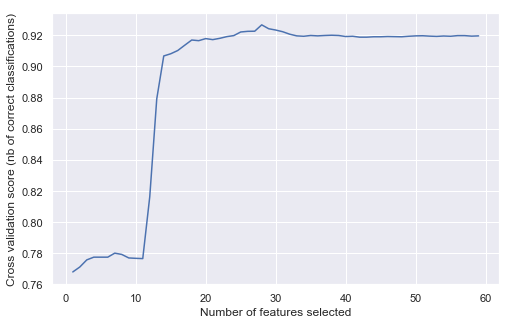

In [34]:
features_list = list(final_df)
features_list.remove(target)

X = final_df.loc[:, features_list]
y = final_df.loc[:, dependent_var]

#Create New Training Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=seed)

#Reduce Features for Optimal Set
X, optimized_model = hf.feature_reduction(LogisticRegression(solver = 'lbfgs'),target_metric, 
                                          X, X_train, y_train)

## Tune hyperparameters to find optimal Ridge Regression Coefficient

GridSearchCV is implemented in order to determine the optimal 'C' (the inverse of λ) and the maximum number of iterations for the model using 10 Kfolds. In the case of the former, doing so helps with model generalization and reduces overfitting as it builds in a penalty that shrinks larger coefficients. Furthermore, Ridge methodology was chosen over Lasso for the purpose of preventing overfitting as well as the fact that there is a relatively small set of variables. In the case of the latter, this sets the ceiling of iterations a solver can take in order to converge to a final model. 

As seen from the below, a penalty of approximately of 1.20 (less strict than the default of 1) and iteration max of 200 (an increase from the deafult of 100) are found to be optimal when cross-validated on the training set. This final model will be used on the holdout set. 

In [35]:
param_grid = {'C': np.arange(1e-05, 3, 0.1), 'max_iter': np.arange(100, 250, 50)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(optimized_model, return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(X_train, y_train.values.ravel())
final_model = gs.best_estimator_ 

print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

best params: LogisticRegression(C=1.2000100000000002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
best params: {'C': 1.2000100000000002, 'max_iter': 200}
best score: 0.919909992499375


# Step 5 - Pipeline 1: Score Model and Obtain Metrics

As seen from the below metrics, it is clear that this final model substantially improves prediction accuracy as well as other scoring metrics from the original base line model. When compared to the best accuracy of the train set as well as from cross-validation, it appears that the model does a fair job of generalizing and does not suffer from overfitting. However, it was previously seen that a non-linear model will likely be needed for this analysis and could provide room for improvement.

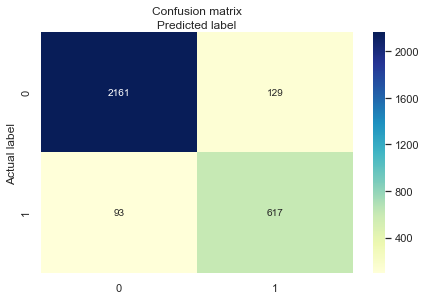

In [36]:
#Score Final Model
y_pred = final_model.predict(X_test)
hf.confusion_heat_map(y_test, y_pred)

In [37]:
final_df = X.join(y)

print('Accuracy of final model on hold-out set: {:.3f}'.format(final_model.score(X_test, y_test)))
test_scores = hf.cv_evaluate(final_df, target, seed, C_input=gs.best_params_['C'], 
                             max_input = gs.best_params_['max_iter'])
print('Average CV accuracy: {:.3f}'.format(np.mean(test_scores)))
print('Best CV accuracy: {:.3f}'.format(np.max(test_scores)))
print()
print(classification_report(y_test, y_pred))

Accuracy of final model on hold-out set: 0.926
Average CV accuracy: 0.928
Best CV accuracy: 0.937

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2290
           1       0.83      0.87      0.85       710

   micro avg       0.93      0.93      0.93      3000
   macro avg       0.89      0.91      0.90      3000
weighted avg       0.93      0.93      0.93      3000



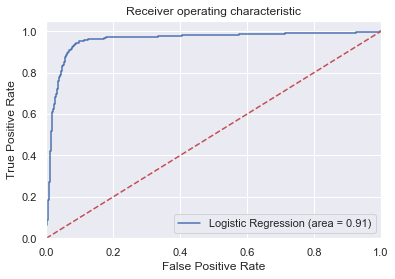

In [38]:
hf.ROC_curve(final_model, y_test, X_test)

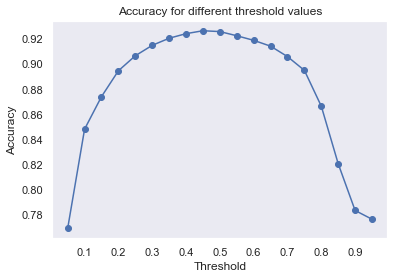

In [39]:
accuracy_list, threshold_list = hf.get_accuracy_list(final_model, X_test, y_test, y_pred)
hf.accuracy_plot(accuracy_list, threshold_list)

# Step 4 - Pipeline 2: Featuring Engineering with Polynomial Features

Another option for feature engineering is making use of Polynomial Features, which generates new variables by creating a matrix of new features based on all polynomial combinations (i.e. given a pair of features a and b, features like a^n or b^n s.t. n is the number of degrees entered as an input). The potential benefits of this are two-fold, 1) it allows for non-linear partitions to be created by the model (i.e. if the distinction between the two classification cannot be drawn from a straight line as seen during the data exploration phase) and 2) increases the signal of variables (though great care must be taken as this inherently can lead to overfitting as the effect of a given variable is increased exponentially). Due to the second point, Polynomial Features is applied to the non-standardized data (i.e. if a variable with an absolute value between 0 and 1 is raised to the nth power, it's signal exponentially approaches 0 as n approaches infinity). After this application, the output data set will be standardized.

Due to the second point, Polynomial Features is applied to the non-standardized data (i.e. if a variable with an absolute value between 0 and 1 is raised to the nth power, it's signal exponentially approaches 0 as n approaches infinity).

In [40]:
# Start with non-standardized data to prevent signal dampening
pol = PolynomialFeatures(4)
pol_df = hf.bin_continuous_var(hf.projects_per_year(encoded_df), override = 'time_spend_company')
pol_features = pol.fit_transform(pol_df[non_bool_numerics])
pol_features = pd.DataFrame(hf.standardize2(pol_features))

print('{} features were created.'.format(pol.n_output_features_))

features = list(booleans)
features.remove(target)

X = pol_features.join(encoded_df[features])

126 features were created.


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


# Feature Reduction
Similar to the first pipeline, several hundred features created from the polynomial features process. Once again the number of features will be reduced, with this process beginning with features variables found to be highly correlated will be removed as well to prevent multicollinearity (unlike the previous pipeline, polynomial features was only applied to exogenous scale numerical values and therefore removing engineered features related to the target and booleans will not be needed).

With these features out of the way Recursive Feature Elimination (RFE) is employed in order to determine the optimal set of features. This makes use of cross validation on the training set with the hopes of creating a less complex model that will minimize overfitting, but still provides the best possible accuracy on the training set.

In [41]:
#Reduce Features based on correlation
X = hf.correlation_removal(X, 0.99)

Need to remove 9 columns with >= 0.99 correlation.


Optimal number of features: 113
Selected features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 56, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 90, 91, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 'Work_accident', 'promotion_last_5years', 'sales_IT', 'sales_RandD', 'sales_hr', 'sales_product_mng', 'salary_high', 'salary_low', 'salary_medium', 'time_spend_company_2', 'time_spend_company_5', 'time_spend_company_6', 'time_spend_company_7', 'time_spend_company_8']


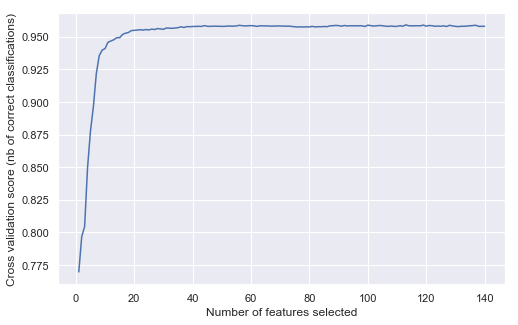

In [42]:
#Create New Training Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=seed)

#Reduce Features for Optimal Set
X, optimized_model = hf.feature_reduction(LogisticRegression(solver = 'lbfgs'),target_metric, 
                                          X, X_train, y_train)

## Tune hyperparameters to find optimal Ridge Regression Coefficient

GridSearchCV is implemented in order to determinte the optimal 'C' (the inverse of λ) and the maximum number of iterations for the model using 10 Kfolds. In the case of the former, doing so helps with model generalization and reduces overfitting as it builds in a penalty that shrinks larger coefficients. Furthermore, Ridge methodology was chosen over Lasso for the purpose of preventing overfitting as well as the fact that there is a relatively small set of variables. In the case of the latter, this sets the ceiling of iterations a solver can take in order to converge to a final model. 

As seen from the below, a penalty of approximately of 2.70 (less harsh than the default of 1) and iteration max of 200 (greater than the default) are found to be optimal when cross-validated on the training set. This final model will be used on the holdout set. 

In [43]:
gs = GridSearchCV(optimized_model, return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(X_train, y_train.values.ravel())
final_model = gs.best_estimator_ 

print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

best params: LogisticRegression(C=2.7000100000000002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
best params: {'C': 2.7000100000000002, 'max_iter': 200}
best score: 0.9600800066672223


# Step 5 - Pipeline 2: Score Model and Obtain Metrics

As seen from the below metrics, it is clear that the final model from this pipeline not only substantially improves upon the base model, but also the final model form the previous pipeline. Analysis of the best accuracy of the train set as well as from cross-validation, supports the notion that the model does a fair job of generalizing and does not suffer from overfitting.

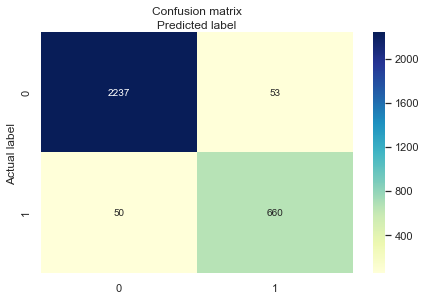

In [44]:
#Score Final Model
y_pred = final_model.predict(X_test)
hf.confusion_heat_map(y_test, y_pred)

In [45]:
final_df = X.join(y)

print('Accuracy of final model on hold-out set: {:.3f}'.format(final_model.score(X_test, y_test)))
test_scores = hf.cv_evaluate(final_df, target, seed, C_input=gs.best_params_['C'], 
                             max_input = gs.best_params_['max_iter'])
print('Average CV accuracy: {:.3f}'.format(np.mean(test_scores)))
print('Best CV accuracy: {:.3f}'.format(np.max(test_scores)))
print()
print(classification_report(y_test, y_pred))

Accuracy of final model on hold-out set: 0.966
Average CV accuracy: 0.961
Best CV accuracy: 0.970

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2290
           1       0.93      0.93      0.93       710

   micro avg       0.97      0.97      0.97      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.97      0.97      0.97      3000



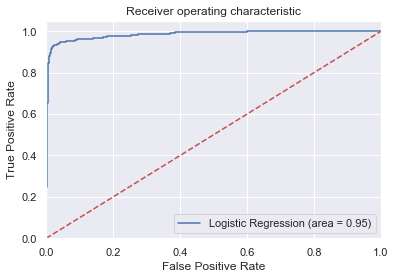

In [46]:
hf.ROC_curve(final_model, y_test, X_test)

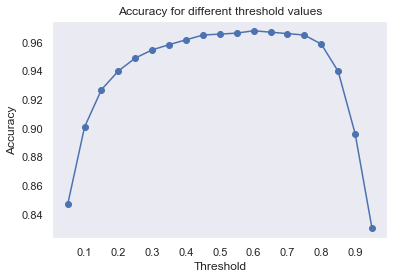

In [47]:
accuracy_list, threshold_list = hf.get_accuracy_list(final_model, X_test, y_test, y_pred)
hf.accuracy_plot(accuracy_list, threshold_list)

# Conclusion

The two pipelines have yielded models with approximately 91% and 96% accuracy when predicting against the test sets. It is interesting to note that there are several explicit variable in common between the two models including "Work_Accident", “promotion_last_5_years”, “salary_high”, the various sales bins and tenure binds. The inclusion of these variables intuitively makes sense as employees who suffered work related accidents most likely would not remain employed with the firm and employees that have been recently promoted might have less incentive to leave. Furthermore, the inclusion of tenure binds supports what was seen during the data exploration phase. The inclusion of sales bins could be explained by the relative difficulty of hitting quotas or harsher lifestyles of different groups. 

This however does not mean that the models do not share other factors in common as both pipelines performed transformations on the originally provided variables (e.g. one model may be using the max of the number of projects, while the other takes this value raised to the 4th power). By including these variables, the model is able to capture their relationships with the employee turnover, which may not be necessarily linear in nature. For this reason and due to its higher score when cross-validated and tested on the holdout, the Polynomial Feature model will be considered the final model.

In [48]:
# Hide code in final report output
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')